ДЗ_№1 - CV_2
====

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [50]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [51]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [52]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [53]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

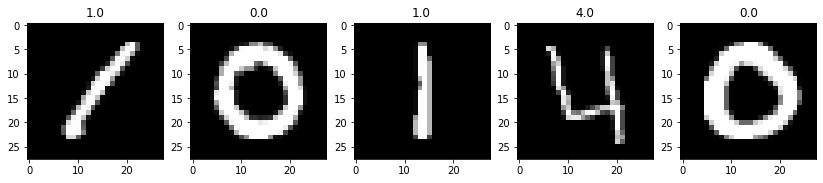

In [82]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [55]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [56]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [57]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [58]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

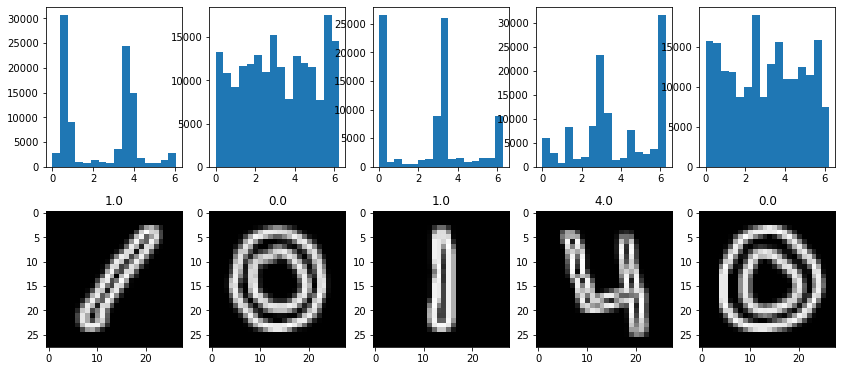

In [59]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [60]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [61]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [62]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [63]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [64]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

PCA
=======

In [65]:
from sklearn.decomposition import PCA

In [66]:
pca = PCA(n_components=12)
pca.fit_transform(x_train)

array([[ 2.07029719e-01,  1.64243868e-01,  1.41217113e-01, ...,
        -3.15128332e-05,  9.37929141e-02, -2.02160457e-02],
       [-3.58128931e-01, -3.42767373e-01,  7.54330315e-02, ...,
        -2.24489032e-02,  6.38597727e-03, -5.78240117e-02],
       [-4.28170638e-01, -2.69237227e-01, -8.59534028e-02, ...,
        -6.05189786e-02,  5.09668879e-03,  2.67584396e-02],
       ...,
       [-4.44389015e-01, -2.31398084e-01, -1.37363894e-01, ...,
        -6.69011047e-02, -8.50865499e-02,  2.01678582e-02],
       [-2.78062845e-01, -6.08437160e-02,  4.87738782e-03, ...,
         1.94876535e-01, -3.70122169e-02, -5.33335164e-02],
       [-1.98348756e-01, -1.76343710e-01, -1.04075264e-01, ...,
         8.74426248e-03, -2.12417190e-02, -6.75817810e-02]])

In [67]:
pca.fit(x_train)
pca.fit(train[:, :784])

PCA(n_components=12)

In [68]:
X_train = pca.transform(train[:, :784])
X_test = pca.transform(test)

In [69]:
y_train, y_val, x_train, x_val = train_test_split(train_label, X_train, test_size=0.2, random_state=42)

KNN Classifier
=====

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
params = {
    'n_neighbors' : np.arange(1, 10)
}

gsearch = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
n_neighbors_best = gsearch.best_params_['n_neighbors']

In [71]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors_best)
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [72]:
y_val_predict = clf.predict(x_val)

In [73]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_val, y_val_predict))

Accuracy:  0.9419047619047619


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       816
         1.0       0.96      0.99      0.98       909
         2.0       0.96      0.95      0.95       846
         3.0       0.94      0.90      0.92       937
         4.0       0.94      0.92      0.93       839
         5.0       0.92      0.94      0.93       702
         6.0       0.94      0.98      0.96       785
         7.0       0.96      0.94      0.95       893
         8.0       0.92      0.92      0.92       835
         9.0       0.89      0.90      0.89       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [75]:
pred_test = clf.predict(X_test).astype(int)

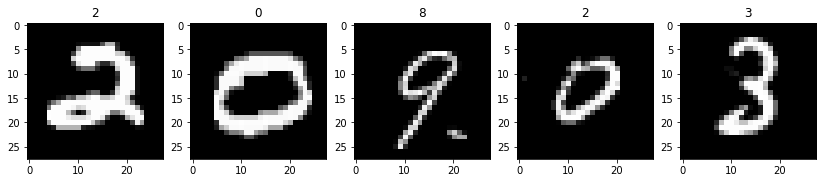

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [46]:
with open('submission_semeshin.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

Скриншот с Kaggle
=====

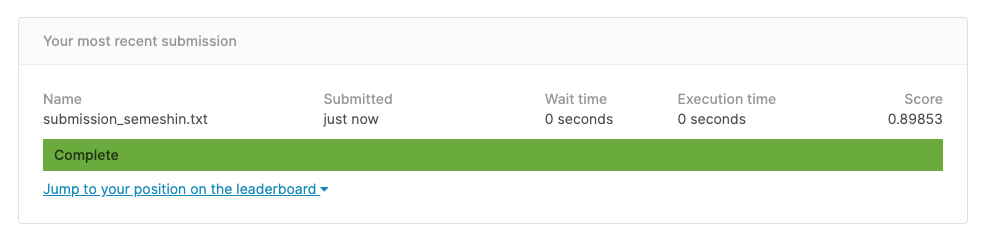

In [77]:
from IPython.display import Image
Image("kaggle_submission.png")

In [78]:
!head submission_semeshin.txt

ImageId,Label
1,2
2,0
3,8
4,2
5,3
6,7
7,0
8,3
9,0
